<strong>Road to pipeline steps:</b>
* Import forecasting pipeline
* define useful features - (no missing values)
* read in the data
* plot sector-wise data
* pivot the data for the particular sector
* plot each data in sector
* check for missing data (just for checks)
* Data cleaning requirements
  * remove outliers (and let prophet input the values). Which simply removes outliers near 0 for all categories


  

# IMPORT LIBRARIES & READ DATA

## importing

In [130]:
import numpy as np
import pandas as pd
import math
import random
import itertools

# visualization
import seaborn as sns
sns.set_style('darkgrid')

# date libraries
from datetime import datetime, timedelta
import holidays

# matplotlib libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import matplotlib.dates as mdates

# scipy library
from scipy import stats
from scipy.stats import norm

# sklearn library
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# prophet library
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import performance_metrics, cross_validation


## defining useful functions

In [9]:
# mean absolute percentage error function
def mape(actual, pred):
    '''
    Mean Absolute Percentage Error (MAPE) Function

    input: list/series for actual values and predicted values
    output: mape value
    '''

    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

## read it!

In [10]:
datapath = 'cleaned_stock_market_data.csv'

In [11]:
restructure_data = pd.read_csv(datapath, parse_dates=['DATE'], index_col='DATE')

In [12]:
restructure_data.head()

SYMBOL  CLOSEPRICE   Volume      Value  NoOfTransaction  OpenPrice  \
DATE                                                                            
2003-01-03    7UP        6.00  29300.0  175314.00             11.0        0.0   
2003-01-06    7UP        5.80  58010.0  337860.80              7.0        0.0   
2003-01-07    7UP        6.00  34550.0  207069.00             12.0        0.0   
2003-01-08    7UP        5.97  16013.0   95625.35             12.0        0.0   
2003-01-09    7UP        5.87  29812.0  176483.64             13.0        0.0   

             EPS   PERatio          SECTOR  
DATE                                        
2003-01-03  3.51  1.709402  CONSUMER GOODS  
2003-01-06  3.51  1.652422  CONSUMER GOODS  
2003-01-07  3.51  1.709402  CONSUMER GOODS  
2003-01-08  3.51  1.700855  CONSUMER GOODS  
2003-01-09  3.51  1.672365  CONSUMER GOODS

# RESTRUCTURING & FILTERING

In [13]:
del restructure_data['Volume']
del restructure_data['Value']
del restructure_data['NoOfTransaction']
del restructure_data['OpenPrice']
del restructure_data['EPS']
del restructure_data['PERatio']

In [14]:
restructure_data

SYMBOL  CLOSEPRICE              SECTOR
DATE                                                  
2003-01-03         7UP        6.00      CONSUMER GOODS
2003-01-06         7UP        5.80      CONSUMER GOODS
2003-01-07         7UP        6.00      CONSUMER GOODS
2003-01-08         7UP        5.97      CONSUMER GOODS
2003-01-09         7UP        5.87      CONSUMER GOODS
...                ...         ...                 ...
2023-02-22  ZENITHBANK       25.20  FINANCIAL SERVICES
2023-02-23  ZENITHBANK       25.35  FINANCIAL SERVICES
2023-02-24  ZENITHBANK       25.75  FINANCIAL SERVICES
2023-02-27  ZENITHBANK       25.95  FINANCIAL SERVICES
2023-02-28  ZENITHBANK       26.50  FINANCIAL SERVICES

[952405 rows x 3 columns]

In [15]:
restructure_data.iloc[945969:945980]

SYMBOL  CLOSEPRICE              SECTOR
DATE                                                
2023-01-04  ABBEYBDS        1.70  FINANCIAL SERVICES
2023-01-05  ABBEYBDS        1.70  FINANCIAL SERVICES
2023-01-06  ABBEYBDS        1.70  FINANCIAL SERVICES
2023-01-09  ABBEYBDS        1.70  FINANCIAL SERVICES
2023-01-10  ABBEYBDS        1.70  FINANCIAL SERVICES
2023-01-11  ABBEYBDS        1.70  FINANCIAL SERVICES
2023-01-12  ABBEYBDS        1.53  FINANCIAL SERVICES
2023-01-13  ABBEYBDS        1.53  FINANCIAL SERVICES
2023-01-16  ABBEYBDS        1.53  FINANCIAL SERVICES
2023-01-17  ABBEYBDS        1.53  FINANCIAL SERVICES
2023-01-18  ABBEYBDS        1.53  FINANCIAL SERVICES

In [16]:
# seperating irrelevant stocks in 2023 from the main dataset
restructure_data_2023 = restructure_data.loc['2023']

unique_stocks_2023 = restructure_data_2023['SYMBOL'].unique() # stocks recorded in 2023
unique_stocks_total = restructure_data['SYMBOL'].unique() # stocks recorded since 2003 to 2023
stocks_not_in_2023 = set(unique_stocks_total) - set(unique_stocks_2023) # irrelevant stocks not in 2023
stocks_not_in_2023_list = list(stocks_not_in_2023) # enlist all irrelevant stocks
print(stocks_not_in_2023_list)

['BECOPETRO', 'PORTPAINT', 'INTRAMOTOR', 'NIGROPES', 'ALUMACO', 'NIGLAMPS', 'NIYAMCO', 'AGIP', 'MANDRID', 'UTC', 'PNG', 'UDEOFSON', 'IHSPREF', 'SKYEBANK', 'CHARTERED', 'PREMBREW', 'SAVANNA', 'IMB', 'PROGBANK', 'RIETZCOT', 'HALLBANK', 'ALPHA', 'NFINSURE', 'CONTINSURE', 'BCC', 'VONO', 'COOPDEV', 'EKOBANK', 'JOSBREW', 'BAICO', 'FIRSTALUM', 'PAINTCOM', 'BEVERAGES', 'AMICABLE', 'MNS', 'LIZOLOFIN', 'AFRPAINTS', 'UNIC', 'CAPALBETO', 'STUDPRESS', 'MTECH', 'NAMPAK', 'ANINO', 'AVONCROWN', 'NIGERCEM', 'ABPLAST', 'AFEXBANK', 'GROMMAC', 'DANGFLOUR', 'GULFBANK', 'ADC', 'NBC', 'AFRIK', 'GCAPPA', 'CERAMIC', 'INITSPLC', 'ONWUTEK', 'REGBANK', 'LAWUNION', 'ATLANTICBK', 'ABATEX', 'LENNARDS', 'INCAR', 'ASABATEXT', 'CONFDINS', 'FSB', 'NIWICABLE', 'FIRSTCAP', 'ENPEE', 'LIBERTY', 'IAINSURE', 'FLEXIBLE', 'CRUSADER', 'CCNN', 'GUARDIANXP', 'UNIONDAC', 'ROADS', 'GNI', 'HIGHLAND', '7UP', 'TIB', 'ROKANA', 'ADSWITCH', 'SPRINGBANK', 'ECOBANK', 'BIGTREAT', 'SUNINS', 'BHN', 'PLATINUM', 'NIGSEWING', 'TROPICPET', 'ASHAKA

In [17]:
len(stocks_not_in_2023_list)

160

In [18]:
restructure_data['SYMBOL'].nunique()

317

In [19]:
# listed irrelevant stocks to remove
stocks_to_remove = ['STUDPRESS', 'TATE', 'INTERCONT', 'ASABATEXT', 'PNG', 'ASHAKACEM', 'ALPHA', 'ALUMACO', 'NIGROPES', 'HALLBANK', 'UNIONDAC', 'LIZOLOFIN', 'UTC', 'PORTPAINT', 'OCEANIC', 'UNIONVENT', 'AFROIL', 'ADC', 'SECASSURE', 'PAINTCOM', 'AMICABLE', '2NDINTERCO', 'GCAPPA', 'NIGERCEM', 'GULFBANK', 'LIBERTY', 'BIGTREAT', 'AFRIK', 'CAPALBETO', 'LAWUNION', 'UNTL', 'INTRAMOTOR', 'ACENINS', 'NIG-GERMAN', 'TRADEBANK', 'NEWPAK', 'TROPICPET', 'NTM', 'COOPBANK', 'LENNARDS', 'BCN', 'IMB', 'AIRSERVICE', 'FIRSTALUM', 'EPICDYNAM', 'STERLING', 'FIRSTCAP', 'WTN', 'OASISINS', 'MANDRID', 'ANINO', 'NIDBFUND', 'RIETZCOT', 'ACBINTBANK', 'BECOPETRO', 'PREMBREW', 'ABOSELAB', 'AFRIBANK', 'OKITIPUPA', 'DANGFLOUR', 'ATLAS', 'CFAO', 'DIAMONDBNK', 'MOBIL', 'NBC', 'NTC', 'WAAP', 'BEVERAGES', 'GROMMAC', 'INITSPLC', 'GUARDIANXP', 'MTI', 'ALBARKAIR', 'UTB', 'FIRSTINLND', 'AFEXBANK', 'BHN', 'LIONBANK', 'NIGSEWING', 'BAGCO', 'EKOBANK', 'NIWICABLE', 'FORTISMFB', 'BEWAC', 'SAVANNA', 'NIGLAMPS', 'OLUGLASS', 'CHRISTLIB', 'IPWA', 'KRABO', 'ALLIEDBANK', 'COOPDEV', 'CHARTERED', 'IHS', 'VONO', 'REGBANK', 'AGLEVENT', 'BCC', 'STARCOMMS', 'CONTINSURE', 'IHSPREF', '7UP', 'GNI', 'ONWUTEK', 'ACB', 'NIGWIRE', 'ROADS', 'MAUREEN', 'CERAMIC', 'STB', 'WAGLASS', 'UNIC', 'PROGBANK', 'WESTEX', 'AVONCROWN', 'DTIMES', 'SUNINS', 'MANNYBANK', 'FSB', 'CONFDINS', 'ABATEX', 'INTBKPREF', 'UDEOFSON', 'CRUSADER', 'FOREMOST', 'JOSBREW', 'NAMPAK', 'ENPEE', 'STOKVIS', 'POLYPROD', 'ROKANA', 'MNS', 'HALLMARK', 'ADSWITCH', 'SKYEBANK', 'ABPLAST', 'COSTAIN', 'HIGHLAND', 'IAINSURE', 'FERDINAND', 'SPRINGBANK', 'CCNN', 'PLATINUM', 'AFPRINT', 'MTECH', 'IHSNGPREF', 'INCAR', 'NIYAMCO', '1STFINBANK', 'FOOTWEAR', 'BAICO', 'TIB', 'ATLANTICBK', 'EVANSMED', 'ECOBANK', 'AGIP', 'FLEXIBLE', 'AFRPAINTS', 'NFINSURE', 'MERCANTILE']

In [20]:
len(stocks_to_remove)

160

In [21]:
# relevant filtered stock data in 2023
relevant_tsdata = restructure_data[~restructure_data['SYMBOL'].isin(stocks_to_remove)]

In [22]:
relevant_tsdata['SYMBOL'].nunique()

157

In [116]:
relevant_tsdata.to_csv('relevant_stock_market_data2.csv', index=True)

In [117]:
relevant = pd.read_csv('relevant_stock_market_data2.csv')

In [118]:
relevant.head()

DATE   SYMBOL  CLOSEPRICE    SECTOR
0  2003-01-02  ACADEMY        0.53  SERVICES
1  2003-01-03  ACADEMY        0.53  SERVICES
2  2003-01-06  ACADEMY        0.53  SERVICES
3  2003-01-07  ACADEMY        0.53  SERVICES
4  2003-01-08  ACADEMY        0.53  SERVICES

# CONGLOMERATE SECTOR DATA

In [24]:
# filtering for the conglomerates
filtered_stock_data = relevant_tsdata[relevant_tsdata['SECTOR'] == 'CONGLOMERATES']

In [25]:
del filtered_stock_data['SECTOR']

In [26]:
filtered_stock_data.head()

SYMBOL  CLOSEPRICE
DATE                             
2003-01-02  CHELLARAM        2.19
2003-01-03  CHELLARAM        2.19
2003-01-06  CHELLARAM        2.19
2003-01-07  CHELLARAM        2.19
2003-01-08  CHELLARAM        2.19

In [27]:
# pivoting the Dataframe to the number of unique symbols
pivoted_tsdata = filtered_stock_data.pivot(columns='SYMBOL', values='CLOSEPRICE')
final_tsdata = pivoted_tsdata.rename(columns={'CHELLARAM': 'CHELLARAM', 'CUSTODIAN': 'CUSTODIAN', 'JOHNHOLT': 'JOHNHOLT',
                                        'SCOA': 'SCOA', 'TRANSCORP': 'TRANSCORP', 'UACN': 'UACN'})


In [28]:
# Resample the data with daily frequency by interpolation
conglomerates_tsdata = final_tsdata.resample('D').interpolate(method='linear')

In [29]:
conglomerates_tsdata.fillna(0, inplace=True)

# PREPROCESSING

## visualization

In [30]:
conglomerates_tsdata

SYMBOL      CHELLARAM  CUSTODIAN  JOHNHOLT  SCOA  TRANSCORP      UACN
DATE                                                                 
2003-01-02       2.19       0.00      0.88  2.55   0.000000  4.280000
2003-01-03       2.19       0.00      0.88  2.55   0.000000  4.350000
2003-01-04       2.19       0.00      0.88  2.55   0.000000  4.363333
2003-01-05       2.19       0.00      0.88  2.55   0.000000  4.376667
2003-01-06       2.19       0.00      0.88  2.55   0.000000  4.390000
...               ...        ...       ...   ...        ...       ...
2023-02-24       1.81       6.00      1.76  1.01   1.300000  9.000000
2023-02-25       1.81       6.00      1.76  1.01   1.286667  9.000000
2023-02-26       1.81       6.00      1.76  1.01   1.273333  9.000000
2023-02-27       1.81       6.00      1.76  1.01   1.260000  9.000000
2023-02-28       1.81       5.95      1.76  1.01   1.340000  9.000000

[7363 rows x 6 columns]

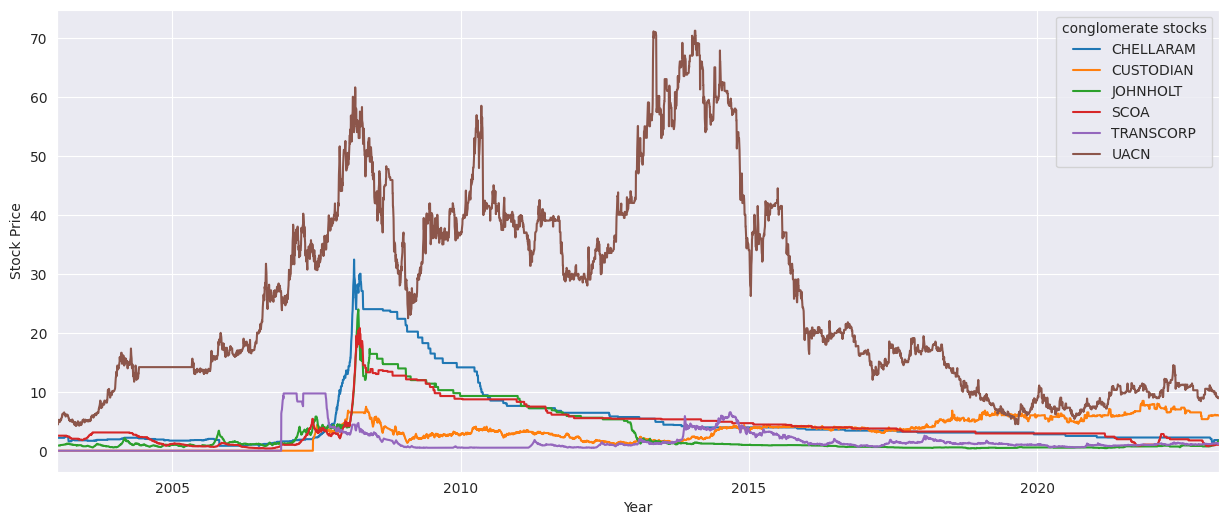

In [31]:
# Plotting
conglomerates_tsdata.plot(figsize=(15, 6))
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend(title='conglomerate stocks', loc='upper right')
plt.show()

## sectoring groupings (LOW/MID/HIGH)

In [32]:
average_closeprices = conglomerates_tsdata.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(conglomerates_tsdata.apply(np.mean, axis=0).sort_values(), [25, 75])

In [33]:
low_vol_cols = list(average_closeprices[average_closeprices <= low].index)
mid_vol_cols = list(average_closeprices[(average_closeprices > low) & (average_closeprices < mid)].index)
high_vol_cols = list(average_closeprices[average_closeprices >= mid].index)

In [34]:
print(f'Low volume stocks are: {low_vol_cols}')
print(f'Middle volume stocks are: {mid_vol_cols}')
print(f'High volume stocks are: {high_vol_cols}')

Low volume stocks are: ['TRANSCORP', 'JOHNHOLT']
Middle volume stocks are: ['CUSTODIAN', 'SCOA']
High volume stocks are: ['CHELLARAM', 'UACN']


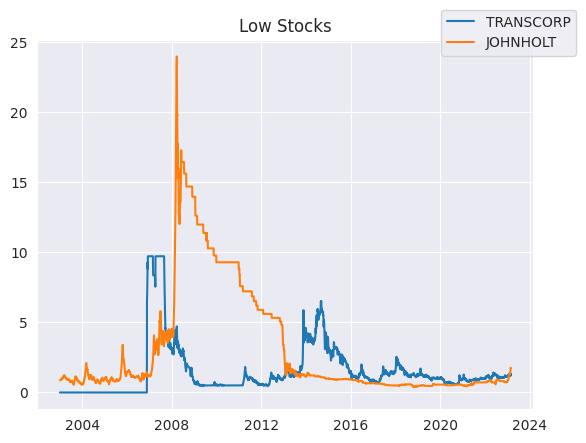

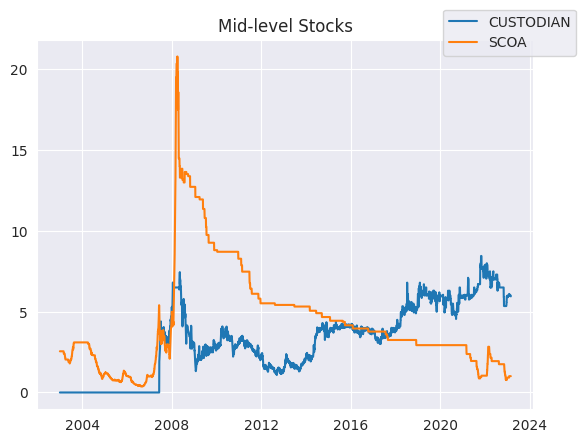

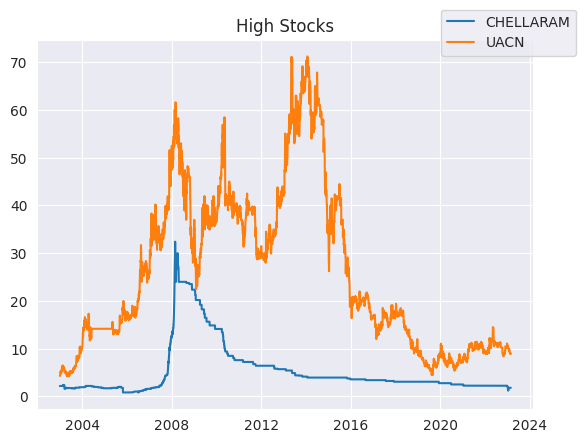

In [35]:
# conglomerates_tsdata[low_vol_cols].plot.line()
plt.plot(conglomerates_tsdata[low_vol_cols])
plt.legend(low_vol_cols, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.title("Low Stocks")
plt.show()

plt.plot(conglomerates_tsdata[mid_vol_cols])
plt.legend(mid_vol_cols, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.title("Mid-level Stocks")
plt.show()

plt.plot(conglomerates_tsdata[high_vol_cols])
plt.legend(high_vol_cols, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.title("High Stocks")
plt.show()

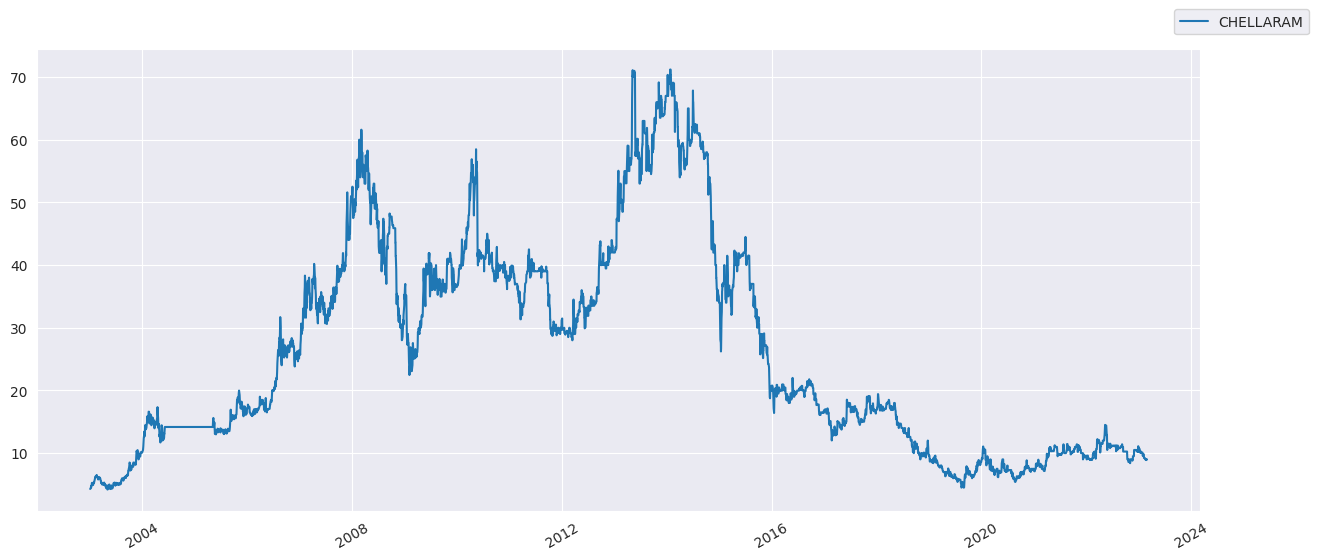

In [36]:
plt.figure(figsize=(15, 6))
plt.plot(conglomerates_tsdata['UACN'])
plt.legend(high_vol_cols, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

## testing the model
using a high volume metric, e.g UACN

In [37]:
# setting variables
feature = 'UACN'
prediction_days = 30

In [38]:
df_uacn = conglomerates_tsdata[[feature]].reset_index()
df_uacn.head()

SYMBOL       DATE      UACN
0      2003-01-02  4.280000
1      2003-01-03  4.350000
2      2003-01-04  4.363333
3      2003-01-05  4.376667
4      2003-01-06  4.390000

In [39]:
len(df_uacn)
len(df_uacn.loc[7304:])

59

In [120]:
#adding holiday data

holiday = pd.DataFrame([])

nigerian_holidays = holidays.NG()  # this is a dict
# the below is the same, but takes a string:
nigerian_holidays = holidays.country_holidays('NG')  # this is a dict


for date_, name in sorted(holidays.NG(years=[2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "NG-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

ds      holiday  lower_window  upper_window
0 2003-01-01  EC-Holidays            -2             1
1 2003-02-11  EC-Holidays            -2             1
2 2003-02-12  EC-Holidays            -2             1
3 2003-04-18  EC-Holidays            -2             1
4 2003-04-21  EC-Holidays            -2             1

https://pypi.org/project/holidays/

In [41]:
from datetime import date

In [42]:
# variables
forecast_start_dt = date(2023,1,1)
forecast_start_date = (forecast_start_dt).strftime('%Y-%m-%d')
print(forecast_start_date)

2023-01-01


Starting the forecast on <b>`2023,1,1`</b>. since our dataset ends on 2023,2,28, therefore there's 59 days of data after the start date. 

Hence this will be a back-testing to see how accurate the model will be. That is, first train the data till the <b>`forecast_start_date`</b>, then forecast for the next 30 days, to see what the accuracy is using <b>`MAPE`</b> (mean absolute percentage error)

# MODELLING

## prophet model

In [43]:
df_uacn.head()

SYMBOL       DATE      UACN
0      2003-01-02  4.280000
1      2003-01-03  4.350000
2      2003-01-04  4.363333
3      2003-01-05  4.376667
4      2003-01-06  4.390000

In [108]:
# using the PROPHET MODEL

df_uacn_copy = df_uacn.copy()
df_uacn_copy = df_uacn_copy.rename(columns={'DATE': 'ds', feature: 'y'})
df_uacn_copy[['y']] = df_uacn_copy[['y']].apply(pd.to_numeric) # make sure that 'y' featrue is a numeric datatype

# affirming that 'ds' is in datetime datatype
df_uacn_copy['ds'] = pd.to_datetime(df_uacn_copy['ds'])

# train data
train_set = df_uacn_copy[(df_uacn_copy['ds'] < forecast_start_date)]

# baseline model
m = Prophet()
m.fit(train_set)
future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

# filter to add only forecasted data to predicted_df
filter = fcst_prophet_train['ds'] >= forecast_start_date
predicted_df = fcst_prophet_train[filter][['ds', 'yhat']]

18:11:15 - cmdstanpy - INFO - Chain [1] start processing
18:12:01 - cmdstanpy - INFO - Chain [1] done processing


In [109]:
predicted_df.head(10)

ds      yhat
7304 2023-01-01  9.042118
7305 2023-01-02  9.058169
7306 2023-01-03  9.086363
7307 2023-01-04  9.132282
7308 2023-01-05  9.152181
7309 2023-01-06  9.225031
7310 2023-01-07  9.253407
7311 2023-01-08  9.283215
7312 2023-01-09  9.316735
7313 2023-01-10  9.362642

<b>`variable considerations for prophet model:`</b> growth, changepoint_prior_scale, changepoint_range, yearly/weekly/daily seasonality, seasonality mode, holidays

## metric evaluation

In [110]:
# merging the original data with the predicted data
df_uacn_copy = df_uacn_copy.copy()
df_uacn_copy.columns = ['ds', 'yoriginal']
predicted_df = predicted_df.merge(df_uacn_copy)

In [111]:
predicted_df.head(10)

ds      yhat  yoriginal
0 2023-01-01  9.042118  10.250000
1 2023-01-02  9.058169  10.250000
2 2023-01-03  9.086363  10.250000
3 2023-01-04  9.132282  10.250000
4 2023-01-05  9.152181  10.750000
5 2023-01-06  9.225031  10.500000
6 2023-01-07  9.253407  10.466667
7 2023-01-08  9.283215  10.433333
8 2023-01-09  9.316735  10.400000
9 2023-01-10  9.362642  10.100000

In [112]:
mape(predicted_df['yoriginal'], predicted_df['yhat'])

5.900040124980903

In [113]:
100 - mape(predicted_df['yoriginal'], predicted_df['yhat'])

94.0999598750191

with our baseline model we have a <b>`94.099..%`</b> accuracy using MAPE metric, which signifies we have a low percentage error of <b>`5.900..%`</b><br><br><hr>

<b>`NOTE:`</b><br> To determine the effective accuracy of the model we'll have to cut off our data at various times within the dates (just like we did for `2023,1,1`), over a large timeframe, so we can normalize. This gives rise to the importance for <b>`cross-validation`</b> 

## cross validation with Prophet

finding the "best" parameters by testing over various periods of time with those parameters (cross-validation)

In [49]:
365 

365

In [79]:
df_uacn_cv = cross_validation(m, initial='365.25 days', period='365.25 days', horizon='30 days')


  0%|                                                    | 0/19 [00:00<?, ?it/s]16:32:47 - cmdstanpy - INFO - Chain [1] start processing
16:32:47 - cmdstanpy - INFO - Chain [1] done processing

  5%|██▎                                         | 1/19 [00:00<00:15,  1.20it/s]16:32:48 - cmdstanpy - INFO - Chain [1] start processing
16:32:49 - cmdstanpy - INFO - Chain [1] done processing

 11%|████▋                                       | 2/19 [00:02<00:20,  1.21s/it]16:32:49 - cmdstanpy - INFO - Chain [1] start processing
16:32:51 - cmdstanpy - INFO - Chain [1] done processing

 16%|██████▉                                     | 3/19 [00:04<00:23,  1.49s/it]16:32:51 - cmdstanpy - INFO - Chain [1] start processing
16:32:52 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████▎                                  | 4/19 [00:05<00:23,  1.55s/it]16:32:53 - cmdstanpy - INFO - Chain [1] start processing
16:32:54 - cmdstanpy - INFO - Chain [1] done processing

 26%|███████████▌            

In [80]:
df_p = performance_metrics(df_uacn_cv)
df_p.head()

horizon        mse      rmse       mae      mape     mdape  \
0 3 days 00:00:00  83.705986  9.149098  7.113030  0.320877  0.284211   
1 3 days 06:00:00  84.913128  9.214832  7.204190  0.323921  0.284211   
2 3 days 12:00:00  85.333113  9.237592  7.224956  0.324544  0.284211   
3 3 days 18:00:00  85.067218  9.223189  7.187765  0.324911  0.284211   
4 4 days 00:00:00  87.475219  9.352819  7.225245  0.326650  0.289834   

      smape  coverage  
0  0.371094  0.438596  
1  0.375525  0.421053  
2  0.376539  0.385965  
3  0.377613  0.403509  
4  0.378651  0.403509

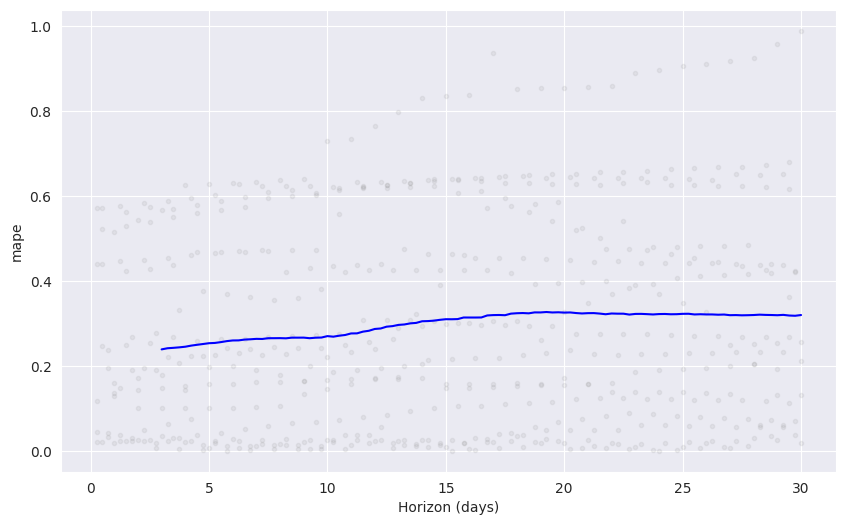

In [87]:
fig = plot_cross_validation_metric(df_uacn_cv, metric = 'mape')

In [81]:
df_p.tail()

horizon         mse       rmse       mae      mape     mdape  \
104 29 days 00:00:00  129.228887  11.367888  8.718725  0.396576  0.280160   
105 29 days 06:00:00  129.361116  11.373703  8.711995  0.395803  0.280160   
106 29 days 12:00:00  128.134558  11.319654  8.681622  0.394480  0.280160   
107 29 days 18:00:00  127.290541  11.282311  8.639088  0.392183  0.280160   
108 30 days 00:00:00  128.904874  11.353628  8.666083  0.393374  0.277853   

        smape  coverage  
104  0.452721  0.280702  
105  0.452034  0.280702  
106  0.451269  0.280702  
107  0.449762  0.298246  
108  0.450271  0.298246

<b>`"df_p"`</b> gives the overall MAPE, but if you want to get more granular and calculate the daily differences using the mape metric, the code is below. This allows you to detect issues in predicting certain time periods, which are inherent issues in the data that you may or may not be able to fix. 
<br><br>
Timeseries is the prime example that <b>`"garbage in"`</b> is going to be <b>`"garbage out"`</b>

In [82]:
df_uacn_cv['mape'] = (df_uacn_cv['y'] - df_uacn_cv['yhat']) / (df_uacn_cv['y']) * 100
df_uacn_cv['overestimate'] = df_uacn_cv['yhat'] > df_uacn_cv['y']

df_uacn_cv.sort_values('mape', ascending=False).head(10)

ds      yhat  yhat_lower  yhat_upper       y              cutoff  \
417 2017-12-28  1.918285   -5.613994    9.091031  16.900 2017-11-30 18:00:00   
419 2017-12-30  1.936724   -5.269219    9.178238  16.900 2017-11-30 18:00:00   
418 2017-12-29  1.947041   -5.765531    9.774702  16.900 2017-11-30 18:00:00   
414 2017-12-25  1.902010   -5.977087    9.059823  16.474 2017-11-30 18:00:00   
413 2017-12-24  1.917071   -5.474284   10.058364  16.556 2017-11-30 18:00:00   
410 2017-12-21  1.937195   -5.480468    9.463460  16.720 2017-11-30 18:00:00   
408 2017-12-19  1.958421   -6.236587    9.801639  16.900 2017-11-30 18:00:00   
415 2017-12-26  1.905173   -4.943201    9.771160  16.392 2017-11-30 18:00:00   
412 2017-12-23  1.934191   -5.506215    9.261453  16.638 2017-11-30 18:00:00   
411 2017-12-22  1.953906   -6.118244   10.245412  16.720 2017-11-30 18:00:00   

          mape  overestimate  
417  88.649198         False  
419  88.540094         False  
418  88.479046         False  
414  88.454473         False  
413  88.420686         False  
410  88.413903         False  
408  88.411711         False  
415  88.377419         False  
412  88.374858         False  
411  88.313958         False

In [84]:
df_uacn_cv.head()

ds       yhat  yhat_lower  yhat_upper      y              cutoff  \
0 2004-12-01  14.782283   14.158706   15.410896  14.17 2004-11-30 12:00:00   
1 2004-12-02  14.792274   14.182554   15.428474  14.17 2004-11-30 12:00:00   
2 2004-12-03  14.825627   14.248689   15.490449  14.17 2004-11-30 12:00:00   
3 2004-12-04  14.796308   14.173129   15.417671  14.17 2004-11-30 12:00:00   
4 2004-12-05  14.765008   14.174030   15.412173  14.17 2004-11-30 12:00:00   

       mape  overestimate  
0 -4.320981          True  
1 -4.391491          True  
2 -4.626869          True  
3 -4.419960          True  
4 -4.199067          True

## configuring hypertuning model

Optimizing for <b>`UACN`</b> feature. What that means is... <b>`'hypertuning this model'`</b>

In [85]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    # 'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

# using cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_set) # fit model with given params
    df_uacn_cv = cross_validation(m, initial='365.25 days', period='365.25 days', horizon='30 days', parallel='processes')
    df_p = performance_metrics(df_uacn_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# finding the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

16:36:18 - cmdstanpy - INFO - Chain [1] start processing
16:36:20 - cmdstanpy - INFO - Chain [1] done processing
16:36:21 - cmdstanpy - INFO - Chain [1] start processing
16:36:21 - cmdstanpy - INFO - Chain [1] start processing
16:36:21 - cmdstanpy - INFO - Chain [1] done processing
16:36:21 - cmdstanpy - INFO - Chain [1] done processing
16:36:22 - cmdstanpy - INFO - Chain [1] start processing
16:36:22 - cmdstanpy - INFO - Chain [1] start processing
16:36:22 - cmdstanpy - INFO - Chain [1] done processing
16:36:23 - cmdstanpy - INFO - Chain [1] done processing
16:36:23 - cmdstanpy - INFO - Chain [1] start processing
16:36:23 - cmdstanpy - INFO - Chain [1] start processing
16:36:24 - cmdstanpy - INFO - Chain [1] done processing
16:36:24 - cmdstanpy - INFO - Chain [1] done processing
16:36:25 - cmdstanpy - INFO - Chain [1] start processing
16:36:25 - cmdstanpy - INFO - Chain [1] start processing
16:36:26 - cmdstanpy - INFO - Chain [1] done processing
16:36:27 - cmdstanpy - INFO - Chain [1]

In [88]:
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale       rmse
0                     0.001                     0.01  15.119684
1                     0.001                     0.10  14.742940
2                     0.001                     1.00  15.007168
3                     0.001                    10.00  15.004916
4                     0.010                     0.01  10.797781
5                     0.010                     0.10  10.852718
6                     0.010                     1.00  10.914053
7                     0.010                    10.00  10.799430
8                     0.500                     0.01   9.414546
9                     0.500                     0.10   9.423571
10                    0.500                     1.00   9.429790
11                    0.500                    10.00   9.429101


In [92]:
tuning_results.sort_values('rmse')

changepoint_prior_scale  seasonality_prior_scale       rmse
8                     0.500                     0.01   9.414546
9                     0.500                     0.10   9.423571
11                    0.500                    10.00   9.429101
10                    0.500                     1.00   9.429790
4                     0.010                     0.01  10.797781
7                     0.010                    10.00  10.799430
5                     0.010                     0.10  10.852718
6                     0.010                     1.00  10.914053
1                     0.001                     0.10  14.742940
3                     0.001                    10.00  15.004916
2                     0.001                     1.00  15.007168
0                     0.001                     0.01  15.119684

In [90]:
tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0]

changepoint_prior_scale    0.500000
seasonality_prior_scale    0.010000
rmse                       9.414546
Name: 0, dtype: float64

## hypertuning model

In [93]:
dict(tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0])

{'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 0.01,
 'rmse': 9.414546029560181}

In [123]:
params_dictionary = dict(tuning_results.sort_values('rmse').reset_index(drop=True).drop('rmse', axis='columns').iloc[0])

model = Prophet(changepoint_prior_scale = params_dictionary['changepoint_prior_scale'],
                seasonality_prior_scale = params_dictionary['seasonality_prior_scale'],
                )

In [133]:
params_dictionary

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}

In [124]:
# hyperparameter tuning the baseline model

model.fit(train_set)
future = model.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

# filter to add only forecasted data to predicted_df
filter = fcst_prophet_train['ds'] >= forecast_start_date
predicted_hypertuned_df = fcst_prophet_train[filter][['ds', 'yhat']]

df_uacn_copy = df_uacn.copy()
df_uacn_copy.columns = ['ds', 'ytrue']
predicted_hypertuned_df = predicted_hypertuned_df.merge(df_uacn_copy)
mape(predicted_hypertuned_df['ytrue'], predicted_hypertuned_df['yhat'])

20:02:17 - cmdstanpy - INFO - Chain [1] start processing
20:03:01 - cmdstanpy - INFO - Chain [1] done processing


5.900040124980903

In [126]:
100 - mape(predicted_hypertuned_df['ytrue'], predicted_hypertuned_df['yhat'])

94.0999598750191

This time with the hypertunning features from both <b>`changepoint_prior_scale`</b> and <b>`seasonality_prior_scale`</b>, there was only a <b>`0.6%`</b> decrease to the metric evaluation; giving a little higher result of <b>`94.619..%`</b> accuracy and MAPE metric of <b>`5.380..%`</b><br><br>

/home/lordmax/.virtualenvs/jupyterworld/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/lordmax/.virtualenvs/jupyterworld/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


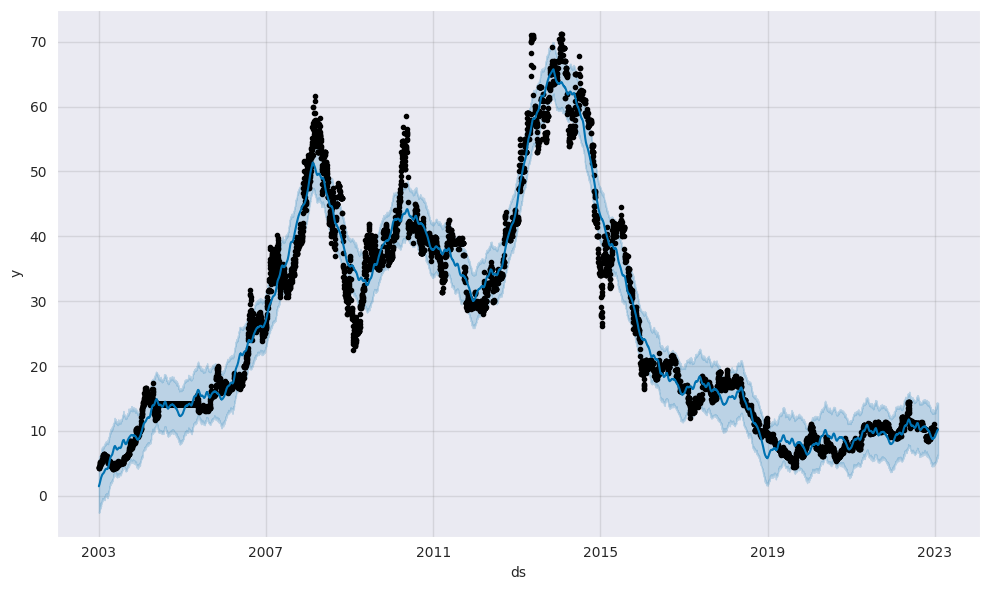

In [134]:
plot1 = model.plot(fcst_prophet_train)

/home/lordmax/.virtualenvs/jupyterworld/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


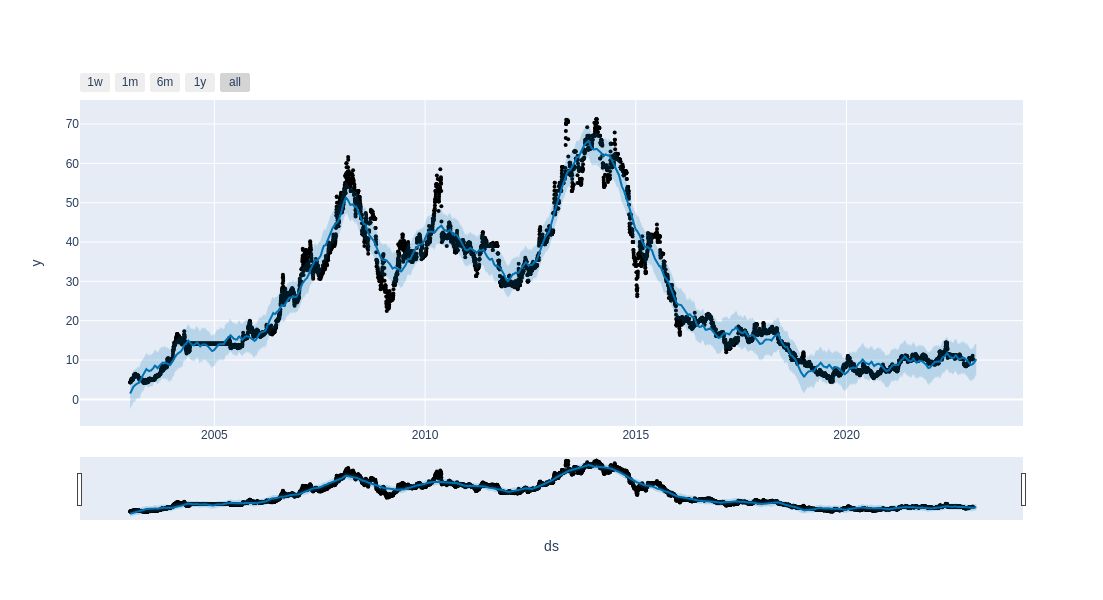

In [135]:
plot_plotly(model, fcst_prophet_train)